# Similarity Classification

In [1]:
import os
import glob
import csv
import pickle
from collections import Counter

import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import functional as F

#### Parameters

In [2]:
path = os.path.join(os.environ['DATASETS'], 'logos')

exemplars_name = os.path.join(path, 'exemplars.zip')
logos_name = os.path.join(path, 'logos', 'all_crops.zip')

exemplars_128_name = os.path.join(path, 'exemplars_128x128.zip')
logos_128_name = os.path.join(path, 'logos', 'all_crops_128x128.zip')

exemplars_siam_name = os.path.join(path, 'exemplars_siamese.zip')
logos_siam_name = os.path.join(path, 'logos', 'all_crops_siamese.zip')

#### Load data

In [3]:
exemplars_df = pd.read_pickle(exemplars_name)
logos_df = pd.read_pickle(logos_name)
logos_df.head()

exemplars_128_df = pd.read_pickle(exemplars_128_name)
logos_128_df = pd.read_pickle(logos_128_name)

exemplars_siam_df = pd.read_pickle(exemplars_siam_name)
logos_siam_df = pd.read_pickle(logos_siam_name)

#### Filter data

In [4]:
logos_brands = Counter(logos_df['brand'])
logos_list = [b for b, c in logos_brands.items() if c >= 50]
brands_mask = logos_df['brand'].isin(logos_list)
too_many = logos_df['brand'] == 'heineken'

logos_small_df = logos_df[brands_mask & ~too_many]
logos_128_small_df = logos_128_df[brands_mask & ~too_many]
logos_siam_small_df = logos_siam_df[brands_mask & ~too_many]

### Analyze latent space

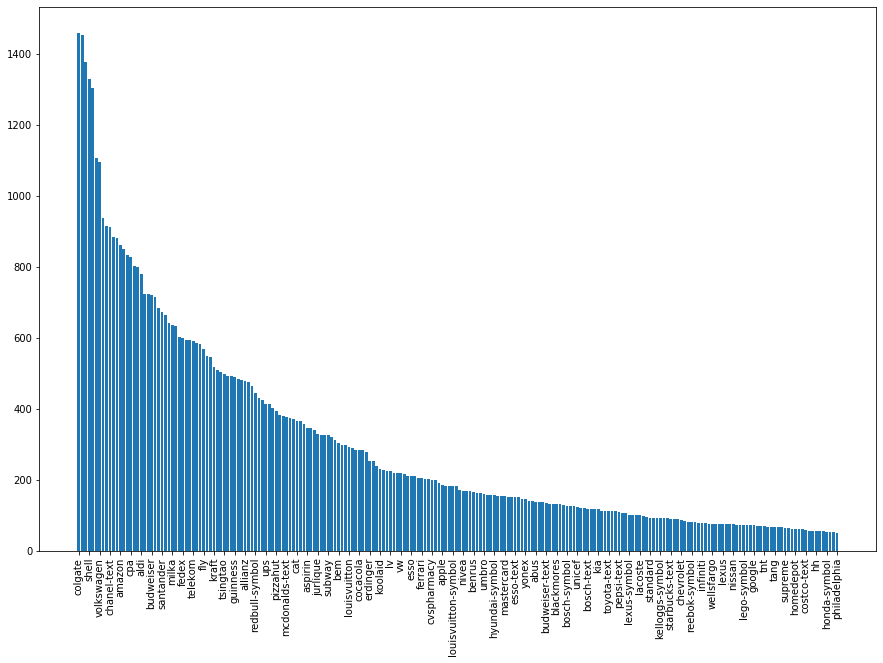

In [5]:
logos_small = Counter(logos_small_df['brand'])

x, y = zip(*logos_small.most_common())
ticks = [v for i, v in enumerate(x) if i % 3 == 0]
labels = [v for i, v in enumerate(logos_small.keys()) if i % 3 == 0]

plt.figure(figsize=(15, 10))
plt.bar(x, y)
plt.xticks(ticks, labels, rotation='vertical');

In [6]:
def get_distances(exemplars, logos, reference, metric, p=None):
    
    detections = set(logos['brand'])
    brands_list = []
    mean_list = []
    min_list = []
    max_list = []
    std_list = []
    var_list = []

    for idx, exemplar_brand in enumerate(tqdm(exemplars['brand'])):

        exemplar_vec = exemplars['img_vec'].iloc[idx]
        if exemplar_brand in detections:

            # Filter brands:
            if reference.lower() == 'tp':
                brand_mask = logos['brand'] == exemplar_brand
            elif reference.lower() == 'fp':
                brand_mask = logos['brand'] != exemplar_brand
            brand_detections = list(logos['img_vec'][brand_mask])
            
            # Compute distances:
            neigh = KNeighborsClassifier(n_neighbors=1, metric=metric, p=p)
            neigh.fit([exemplar_vec], [1])
            dists, classes = neigh.kneighbors(brand_detections)

            brands_list.append(exemplar_brand)
            mean_list.append(np.mean(dists))
            min_list.append(np.min(dists))
            max_list.append(np.max(dists))
            std_list.append(np.std(dists))
            var_list.append(np.var(dists))

    dists_mat = pd.DataFrame({
        'brand': brands_list,
        'mean': mean_list,
        'min': min_list,
        'max': max_list,
        'std': std_list,
        'var': var_list
        })

    return dists_mat

In [7]:
def plot_distances(mat_1, mat_2, mat_3, mat_4, mat_5, mat_6):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    labels = ['Exem - TPs', 'Exem - FPs']

    data = np.array((mat_1['mean'], mat_4['mean'])).T
    norm = normalize(data, axis=0, norm='l2')
    axs[0].boxplot(norm, widths=0.75, labels=labels);
    axs[0].set_title('Minkowski: 1');

    data = np.array((mat_2['mean'], mat_5['mean'])).T
    norm = normalize(data, axis=0, norm='l2')
    axs[1].boxplot(norm, widths=0.75, labels=labels);
    axs[1].set_title('Minkowski: 2');

    data = np.array((mat_3['mean'], mat_6['mean'])).T
    norm = normalize(data, axis=0, norm='l2')
    axs[2].boxplot(norm, widths=0.75, labels=labels);
    axs[2].set_title('Cosine');

## Crops of varying size

### Average distance: Exemplar to TPs

##### Minkowski: 1

In [8]:
dists_mat_1 = get_distances(exemplars_df, logos_small_df, 'TP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:00<00:00, 1107.01it/s]


##### Minkowski: 2

In [9]:
dists_mat_2 = get_distances(exemplars_df, logos_small_df, 'TP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:00<00:00, 434.80it/s]


#### Cosine

In [10]:
dists_mat_3 = get_distances(exemplars_df, logos_small_df, 'TP', metric='cosine')

100%|██████████| 352/352 [00:00<00:00, 389.02it/s]


### Average distance: Exemplar to FPs

##### Minkowski: 1

In [11]:
dists_mat_4 = get_distances(exemplars_df, logos_small_df, 'FP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:09<00:00, 35.45it/s]


##### Minkowski: 2

In [12]:
dists_mat_5 = get_distances(exemplars_df, logos_small_df, 'FP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:13<00:00, 25.27it/s]


##### Cosine

In [13]:
dists_mat_6 = get_distances(exemplars_df, logos_small_df, 'FP', metric='cosine')

100%|██████████| 352/352 [00:22<00:00, 15.50it/s]


### Results

In [14]:
dists_mat_1.describe()

,mean,min,max,std,var
count,57.000000,57.000000,57.000000,57.000000,57.000000
mean,14.485614,7.991306,17.663177,1.742497,3.184492
std,1.032177,2.134163,0.777958,0.388386,1.409741
min,11.484476,2.611554,16.012423,0.991354,0.982783
25%,13.867979,6.328202,17.201457,1.476908,2.181256
50%,14.480668,8.085523,17.560186,1.751951,3.069333
75%,15.272189,9.288979,18.217433,2.032402,4.130659
max,16.484000,13.137678,20.051583,2.812041,7.907576


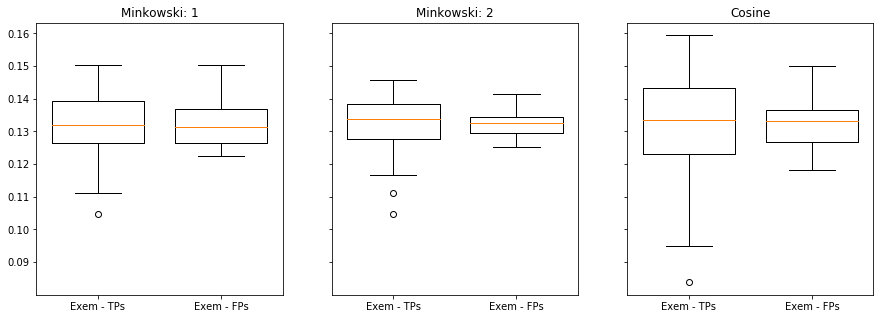

In [15]:
plot_distances(dists_mat_1, dists_mat_2, dists_mat_3,
               dists_mat_4, dists_mat_5, dists_mat_6)

## Crops of size 128x128

### Average distance: Exemplar to TPs

##### Minkowski: 1

In [16]:
dists_mat_7 = get_distances(exemplars_128_df, logos_128_small_df, 'TP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:00<00:00, 1119.64it/s]


##### Minkowski: 2

In [17]:
dists_mat_8 = get_distances(exemplars_128_df, logos_128_small_df, 'TP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:00<00:00, 420.52it/s]


#### Cosine

In [18]:
dists_mat_9 = get_distances(exemplars_128_df, logos_128_small_df, 'TP', metric='cosine')

100%|██████████| 352/352 [00:00<00:00, 377.56it/s]


### Average distance: Exemplar to FPs

##### Minkowski: 1

In [19]:
dists_mat_10 = get_distances(exemplars_128_df, logos_128_small_df, 'FP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:10<00:00, 34.97it/s]


##### Minkowski: 2

In [20]:
dists_mat_11 = get_distances(exemplars_128_df, logos_128_small_df, 'FP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:13<00:00, 25.23it/s]


##### Cosine

In [21]:
dists_mat_12 = get_distances(exemplars_128_df, logos_128_small_df, 'FP', metric='cosine')

100%|██████████| 352/352 [00:23<00:00, 15.26it/s]


### Results

In [22]:
dists_mat_7.describe()

,mean,min,max,std,var
count,57.000000,57.000000,57.000000,57.000000,57.000000
mean,13.732492,6.933087,16.742772,1.767445,3.338172
std,1.075168,2.054832,0.593032,0.467053,1.819058
min,10.260691,3.186702,15.107853,1.019491,1.039363
25%,13.189273,5.335862,16.417082,1.362081,1.855263
50%,13.805812,7.016550,16.758257,1.694979,2.872954
75%,14.531166,8.314339,17.158119,1.970955,3.884664
max,15.399660,11.550732,18.003920,2.910491,8.470960


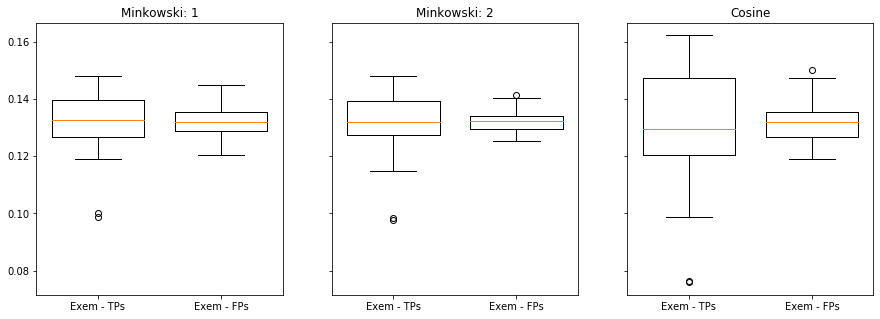

In [23]:
plot_distances(dists_mat_7, dists_mat_8, dists_mat_9,
               dists_mat_10, dists_mat_11, dists_mat_12)

## Siamese Embedding

### Average distance: Exemplar to TPs

##### Minkowski: 1

In [24]:
dists_mat_13 = get_distances(exemplars_siam_df, logos_siam_small_df, 'TP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:00<00:00, 1131.35it/s]


##### Minkowski: 2

In [25]:
dists_mat_14 = get_distances(exemplars_siam_df, logos_siam_small_df, 'TP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:00<00:00, 443.80it/s]


#### Cosine

In [26]:
dists_mat_15 = get_distances(exemplars_siam_df, logos_siam_small_df, 'TP', metric='cosine')

100%|██████████| 352/352 [00:00<00:00, 365.65it/s]


### Average distance: Exemplar to FPs

##### Minkowski: 1

In [27]:
dists_mat_16 = get_distances(exemplars_siam_df, logos_siam_small_df, 'FP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:07<00:00, 45.87it/s]


##### Minkowski: 2

In [28]:
dists_mat_17 = get_distances(exemplars_siam_df, logos_siam_small_df, 'FP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:11<00:00, 30.26it/s]


##### Cosine

In [29]:
dists_mat_18 = get_distances(exemplars_siam_df, logos_siam_small_df, 'FP', metric='cosine')

100%|██████████| 352/352 [00:17<00:00, 20.20it/s]


### Results

In [30]:
dists_mat_13.describe()

,mean,min,max,std,var
count,57.000000,57.000000,57.000000,57.000000,57.000000
mean,1.980660,0.255037,3.614266,0.852133,0.781313
std,0.631713,0.168840,0.416597,0.236997,0.424094
min,0.814992,0.080851,2.228448,0.315199,0.099351
25%,1.512001,0.162265,3.347833,0.687614,0.472814
50%,1.952160,0.194007,3.580223,0.821712,0.675210
75%,2.346441,0.305870,3.933201,0.995630,0.991280
max,3.276855,0.831206,4.386363,1.360421,1.850744


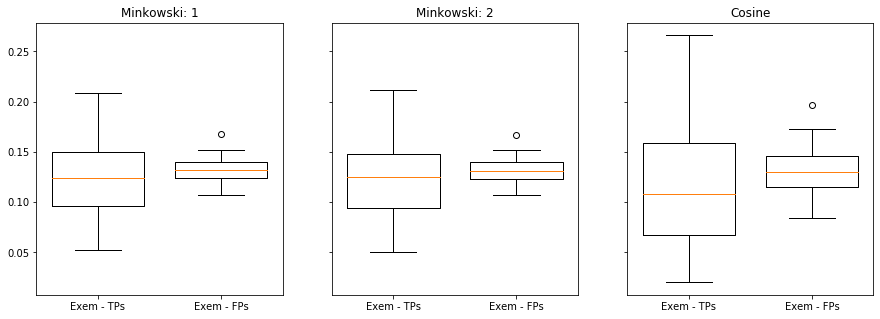

In [31]:
plot_distances(dists_mat_13, dists_mat_14, dists_mat_15,
               dists_mat_16, dists_mat_17, dists_mat_18)